In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ip = "52.233.29.106"
duckdb.sql("INSTALL postgres;")
duckdb.sql("LOAD postgres;")
duckdb.sql(f"ATTACH 'dbname=postgres user=postgres host={ip} password=template!PWD' AS db (TYPE POSTGRES);")


In [5]:
duckdb.query("""
SELECT * FROM db.public.compute_configs
""")

CatalogException: Catalog Error: Table with name compute_configs does not exist!
Did you mean "db.pg_catalog.pg_config"?

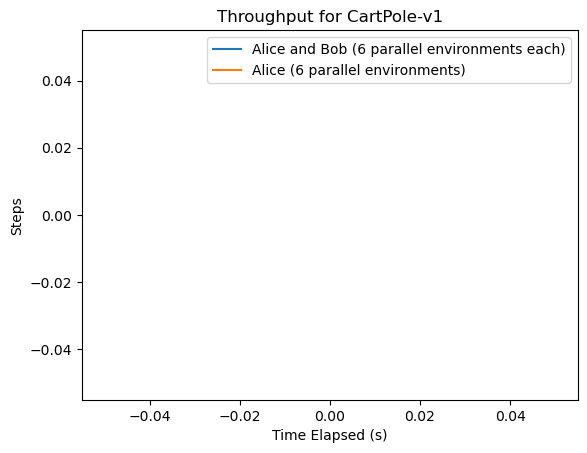

In [19]:
df_2_workers = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
WHERE run_id = '008da3c6-d0aa-410e-a895-e3535285b6c2'
ORDER BY time
""").df()

df_1_worker = duckdb.query("""
SELECT time, COUNT(*) OVER (ORDER BY time ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) as num_steps
FROM db.public.training
WHERE run_id = 'f15dd0eb-eb89-4bf9-9995-582b4d39c3de'
ORDER BY time
""").df()

for df in [df_2_workers, df_1_worker]:
    df['elapsed_time'] = df['time'] - df['time'].min()


plt.plot(df_2_workers['elapsed_time'], df_2_workers['num_steps'], label='Alice and Bob (6 parallel environments each)')
plt.plot(df_1_worker['elapsed_time'], df_1_worker['num_steps'], label='Alice (6 parallel environments)')

plt.ylabel('Steps')
plt.xlabel('Time Elapsed (s)')
plt.title("Throughput for CartPole-v1")
plt.legend()

In [22]:
duckdb.query("""
SELECT * FROM db.public.cpu_utilization
WHERE run_id = 'ea9c34f6-005f-4a7d-9607-ef9baae31a3f'
AND worker = 'alice'
""")

┌──────────────────────────────────────┬────────────────────┬─────────┬───────┬─────────────┐
│                run_id                │        time        │ worker  │ core  │ utilization │
│                 uuid                 │       double       │ varchar │ int32 │   double    │
├──────────────────────────────────────┼────────────────────┼─────────┼───────┼─────────────┤
│ ea9c34f6-005f-4a7d-9607-ef9baae31a3f │ 1723270525.8988917 │ alice   │     0 │         0.0 │
│ ea9c34f6-005f-4a7d-9607-ef9baae31a3f │ 1723270525.8988917 │ alice   │     1 │         0.1 │
│ ea9c34f6-005f-4a7d-9607-ef9baae31a3f │ 1723270525.8988917 │ alice   │     2 │         0.1 │
│ ea9c34f6-005f-4a7d-9607-ef9baae31a3f │ 1723270525.8988917 │ alice   │     3 │         0.1 │
│ ea9c34f6-005f-4a7d-9607-ef9baae31a3f │ 1723270525.8988917 │ alice   │     4 │         0.1 │
│ ea9c34f6-005f-4a7d-9607-ef9baae31a3f │ 1723270525.8988917 │ alice   │     5 │         0.1 │
│ ea9c34f6-005f-4a7d-9607-ef9baae31a3f │ 1723270525.8988917 

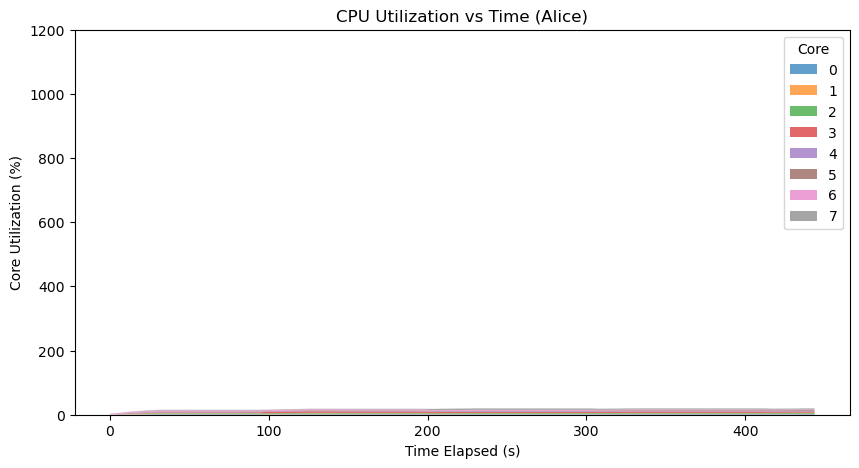

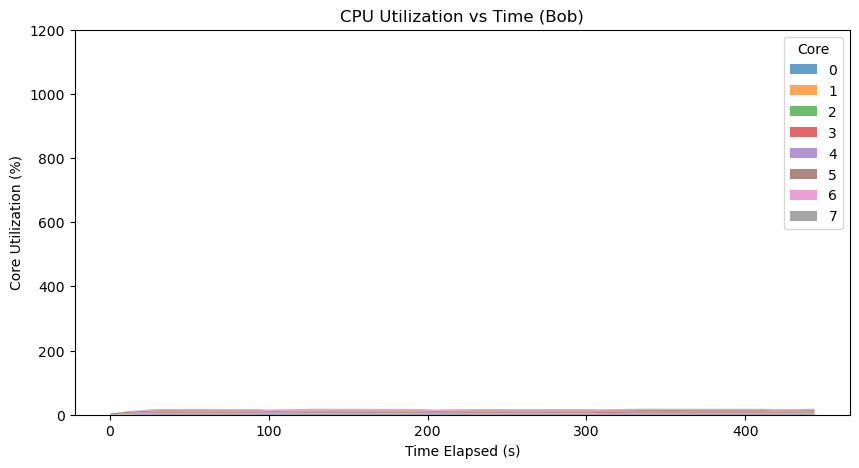

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from scipy.ndimage import gaussian_filter1d

# Define the workers you want to plot
workers = ['alice', 'bob']

# Define smoothing function
def smooth_data(data, window_size):
    return data.rolling(window=window_size, min_periods=1).mean()

# Plotting for each worker
for worker in workers:
    # Query and prepare the data
    df = duckdb.query(f"""
    SELECT * FROM db.public.cpu_utilization
    WHERE worker = '{worker}'
    AND run_id = 'ea9c34f6-005f-4a7d-9607-ef9baae31a3f'
    """).df()

    # Calculate time elapsed
    df['time_elapsed'] = df['time'] - df['time'].min()

    # Pivot the DataFrame for plotting
    pivot_df = df.pivot_table(index='time_elapsed', columns='core', values='utilization', aggfunc='mean')

    # Smooth the data
    window_size = 5  # Adjust window size as needed
    smoothed_df = pivot_df.apply(lambda x: smooth_data(pd.Series(x), window_size))

    # Create a new figure for each worker
    plt.figure(figsize=(10, 5))

    # Plotting
    plt.stackplot(smoothed_df.index, smoothed_df.T, labels=smoothed_df.columns, alpha=0.7)

    
    # Set title based on worker type
    if worker == "alice":
        plt.title(f'CPU Utilization vs Time (Alice)')
    elif worker == "bob":
        plt.title(f'CPU Utilization vs Time (Bob)')

    plt.xlabel('Time Elapsed (s)')
    plt.ylabel('Core Utilization (%)')
    plt.ylim(0, 1200)
    plt.legend(title='Core')

    plt.show()
    # Save the figure
    plt.savefig(f"./figures/cpu_utilization_{worker}.png")
    
    # Close the figure
    plt.close()
